# Automatic Defect Inspection with End-to-End Deep Learning

Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.

This dataset consists of multiple data sets, each consisting of 1000 images without defects, and of 150 images with one labeled defect each on the background texture. The images in a single data set are very similar, but each data set is generated by a different texture model and defect model.

##### Libraries

In [ ]:
import os
import numpy as np
import cv2
from coslib import plot_ellipse_seg_test
from coslib import load_images_masks

# Visualization
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Modeling
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

!pip install xmltodict

## Data Loading

In [1]:
!git clone https://github.com/Tony607/Industrial-Defect-Inspection-segmentation
%cd /content/Industrial-Defect-Inspection-segmentation
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .
data_dir = "./Class1_def"

Cloning into 'Industrial-Defect-Inspection-segmentation'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 0), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.
/content/Industrial-Defect-Inspection-segmentation


## Preprocessing

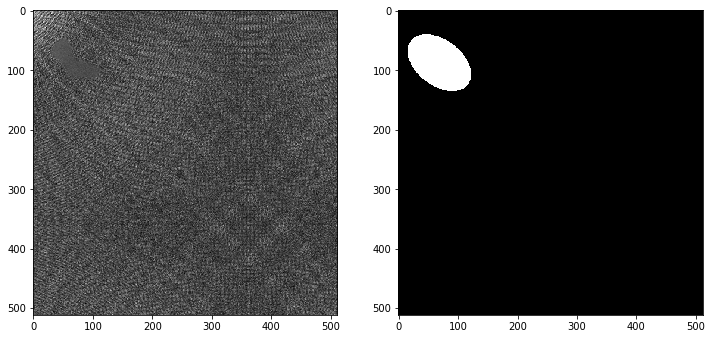

In [7]:
plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

Each file is made up of two images: the first, a background texture, representing a microcoping image from a piece of equipment; the second, an ellipse defining identifying the defect.

In [ ]:
X, y = load_images_masks(data_dir, img_type = 'png', img_format = 'gray', resize = (512, 512), ellipse = True)

## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [16]:
X_train.shape

(105, 512, 512, 1)

In [17]:
X_test.shape

(45, 512, 512, 1)

We have 105 images for our training set, and 45 images for our testing set; each image is 512 x 512.

## Modeling

In [ ]:
img_rows = 512
img_cols = 512

We will use a U-Net, which is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin.

#### U-Net Architecture

In [ ]:
def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [21]:
model = get_small_unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Loss Function

We will use dice loss as our training loss function; which is often used for boundary detection tasks in computer vision. We also use the Intersection over Union for model evaluation.

In [ ]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

## Training

In [24]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Train on 94 samples, validate on 11 samples
Epoch 1/50
94/94 [==============================] - 21s 228ms/sample - loss: -0.0741 - IOU_calc: 0.0744 - val_loss: -0.0985 - val_IOU_calc: 0.1306
Epoch 2/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.0785 - IOU_calc: 0.0787 - val_loss: -0.1046 - val_IOU_calc: 0.0873
Epoch 3/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.0868 - IOU_calc: 0.0881 - val_loss: -0.1216 - val_IOU_calc: 0.1033
Epoch 4/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.1164 - IOU_calc: 0.1191 - val_loss: -0.1912 - val_IOU_calc: 0.1949
Epoch 5/50
94/94 [==============================] - 6s 67ms/sample - loss: -0.2190 - IOU_calc: 0.2192 - val_loss: -0.2458 - val_IOU_calc: 0.2094
Epoch 6/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.2868 - IOU_calc: 0.2862 - val_loss: -0.3206 - val_IOU_calc: 0.2969
Epoch 7/50
94/94 [==============================] - 6s 66ms/sample - loss: -0.3164 -

## Training Evaluation

#### Training Loss through Epochs

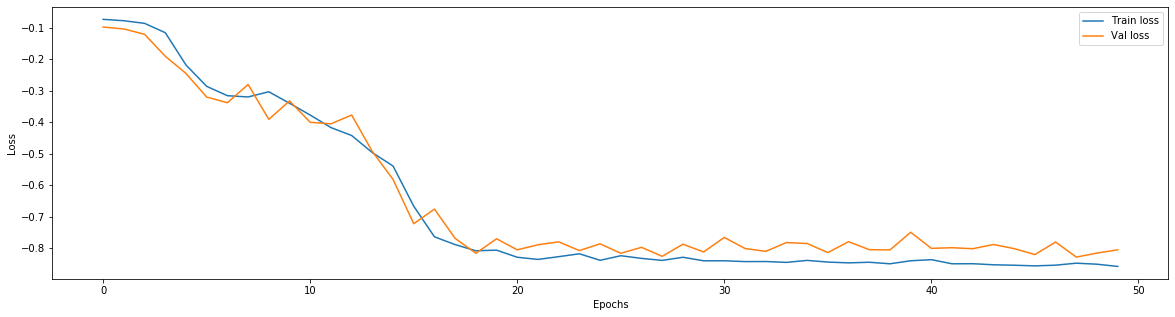

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### IoU Evaluation through Epochs

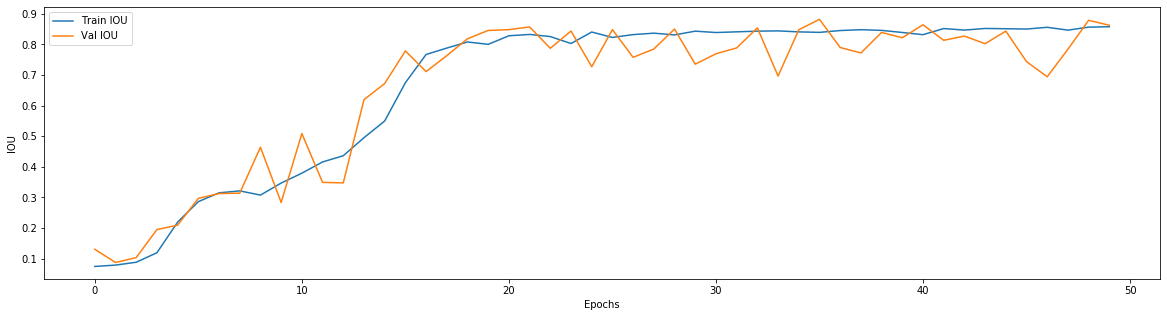

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

## Prediction and Inference

In [ ]:
predict = model.predict(X_test)

In [ ]:
def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

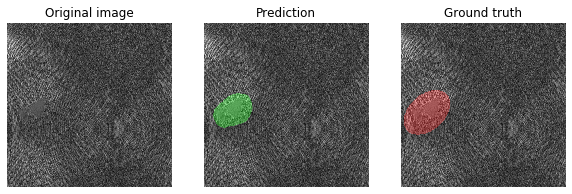

In [29]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

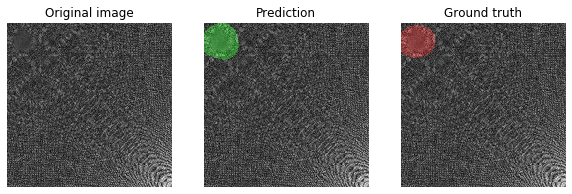

In [30]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

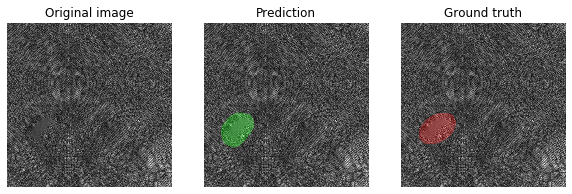

In [31]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

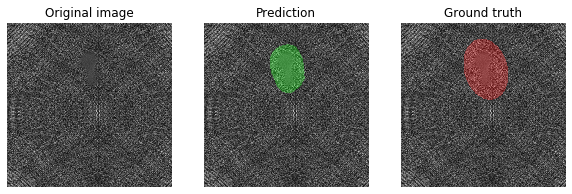

In [32]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

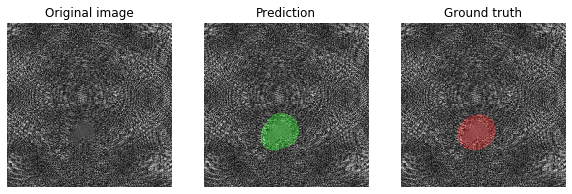

In [33]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

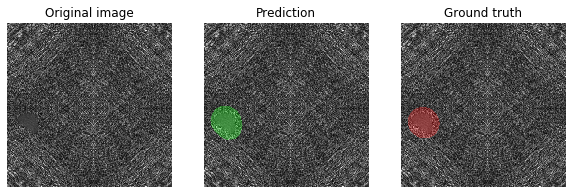

In [34]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

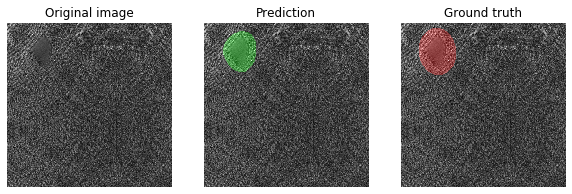

In [35]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

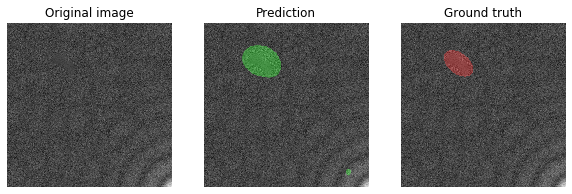

In [36]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

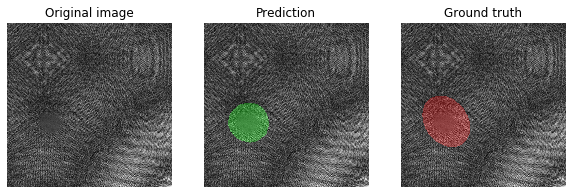

In [37]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

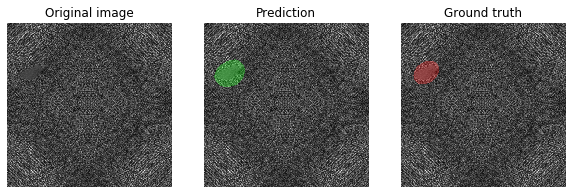

In [38]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])